# BMTs on the Sphere

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics.pairwise import pairwise_distances
import networkx as nx
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import cKDTree

from mergeTrees import *

The following functions give some tools for generating and visualizing a distribution on the 2-sphere.

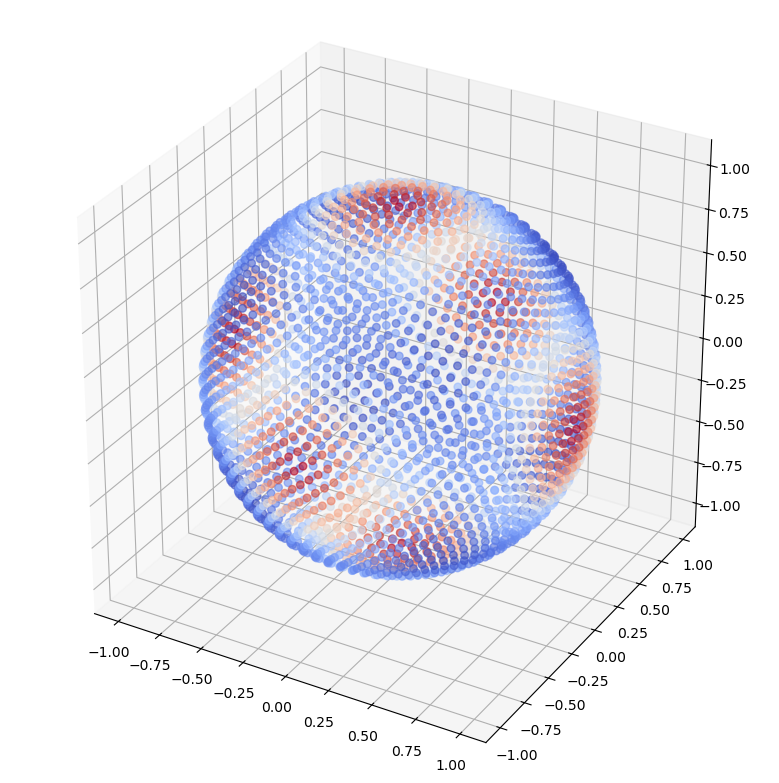

In [89]:
def generate_unit_sphere_mesh(n_points=5000):
    """Generate approximately uniform points on the unit sphere using the Fibonacci method."""
    indices = np.arange(0, n_points, dtype=float) + 0.5
    phi = np.arccos(1 - 2*indices/n_points)
    theta = np.pi * (1 + 5**0.5) * indices

    x = np.cos(theta) * np.sin(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(phi)
    return np.vstack((x, y, z)).T

def spherical_pdf(points, centers, bandwidth):
    """Compute a smooth pdf on the sphere using Gaussian kernels centered at `centers`."""
    pdf_vals = np.zeros(points.shape[0])
    for center in centers:
        cos_dists = np.clip(points @ center, -1.0, 1.0)
        angles = np.arccos(cos_dists)
        pdf_vals += np.exp(-0.5 * (angles / bandwidth)**2)
    pdf_vals /= np.sum(pdf_vals)
    return pdf_vals

def build_graph_on_sphere(points, pdf_vals, k=10):
    """Build a kNN graph on sphere points with pdf values."""
    tree = cKDTree(points)
    distances, indices = tree.query(points, k=k+1)  # include self

    G = nx.Graph()
    for i, point in enumerate(points):
        G.add_node(i, pos=point, pdf=pdf_vals[i])
        for j in indices[i][1:]:  # skip self
            dist = np.linalg.norm(points[i] - points[j])
            G.add_edge(i, j, weight=dist)
    return G

# --- Usage ---
np.random.seed(3)

num_samp = 2500

mesh_points = generate_unit_sphere_mesh(n_points=num_samp)

# Define 3 well-separated mode centers
modes = np.array([
    [1, 0, 0],
    [0,0,1],
    [0,0,-1],
    [-1,0, 0],
    [0,1,0],
    [0,-1,0]
])


modes = modes / np.linalg.norm(modes, axis=1, keepdims=True)

# Define PDF
pdf_values = spherical_pdf(mesh_points, centers=modes, bandwidth=0.4)

# Build graph
G = build_graph_on_sphere(mesh_points, pdf_values, k=10)

pos = nx.get_node_attributes(G, 'pos')
pdf = nx.get_node_attributes(G, 'pdf')

xyz = np.array([pos[i] for i in G.nodes()])
pdf_vals = np.array([pdf[i] for i in G.nodes()])

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], c=pdf_vals, cmap='coolwarm', s=30, alpha = 0.6)
ax.set_box_aspect([1,1,1])
plt.savefig('sphere_distribution.png', format='png', dpi=300)
plt.tight_layout()
plt.show()

Next we generate a BMT for the distribution. First we need a function which computes spherical distances:

In [90]:
def sphere_distances(X):
    
    # X is a nx3 array of points on a unit sphere
    # Output D is the pairwise geodesic distance matrix
    
    Gram = X@X.T
    D = np.arccos(np.minimum(Gram,1))
    
    return D

Now we define necessary parameters and plot the BMT.

In [91]:
dx = 4*np.pi/num_samp
p=2
D = sphere_distances(mesh_points)
deviation_values = np.sum(D**p*pdf_values*dx,axis = 1)**(1/p)

In [92]:
f = {i:deviation_values[i] for i in range(len(G))}

T = simplify_merge_tree(get_merge_tree(G,f))

In [93]:
import matplotlib.colors as mcolors
import colorsys

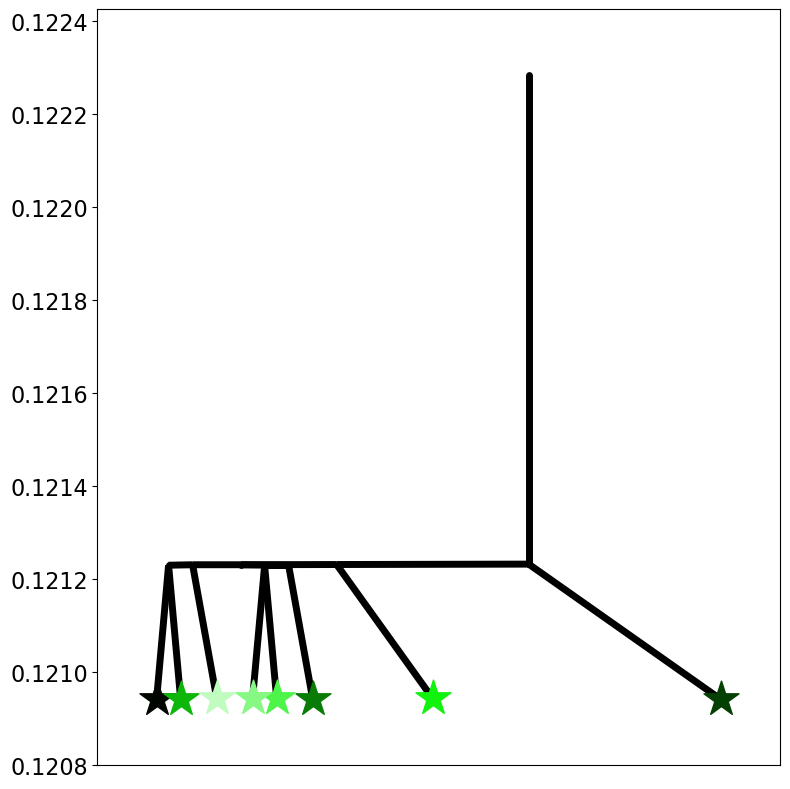

In [94]:
height = {node:T.nodes[node]['height'] for node in T.nodes()}
pos = mergeTree_pos(T,height)

fig, ax = plt.subplots(figsize=(8, 8))

nx.draw_networkx(T, pos=pos, with_labels=False,node_size = 15, node_color='black',width = 5)

leaves = [node for node in T if nx.degree(T)[node] == 1]
leaves.pop();

# Define a fixed green hue (around 120 degrees -> 120/360 = 0.33 in HSL)
hue = 0.33         # green
saturation = 0.9   # strong green
lightness_vals = np.linspace(0.01,0.99,len(leaves)+1)  # from dark to light

# Generate list of green colors in increasing lightness
green_colors = [colorsys.hls_to_rgb(hue, l, saturation) for l in lightness_vals]

# Optionally convert RGB values to hex for use in matplotlib
green_colors_hex = [mcolors.to_hex(rgb) for rgb in green_colors]

for i,node in enumerate(leaves):
    
    x_min = np.array([pos[node][0]])
    y_min = np.array([pos[node][1]])
    plt.scatter(x_min, y_min, color=green_colors_hex[i], s=700, marker="*", label="Fréchet Means", alpha=1,zorder=10)

ax.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, labelsize = 16)
# ax.set_ylim(1.5, 2.2)

plt.tight_layout()
plt.savefig('sphere_distribution_tree.png', format='png', dpi=300)

Finally, we plot the sphere with the points corresponding to leaves of the tree indicated.

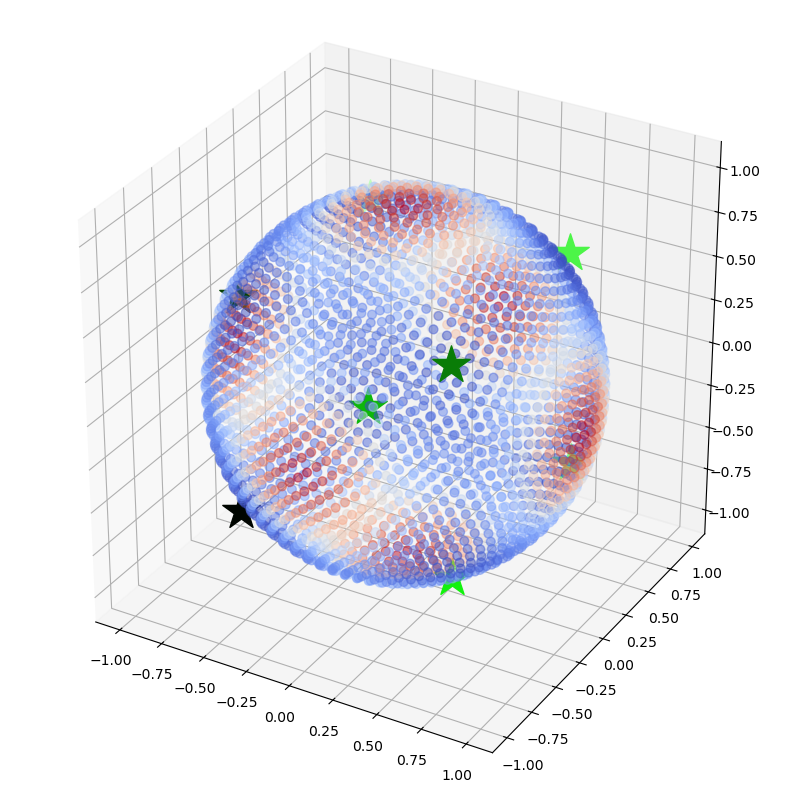

In [97]:
# Build graph
G1 = build_graph_on_sphere(mesh_points, deviation_values, k=10)

# Visualize
# visualize_graph_on_sphere(G1)

pos1 = nx.get_node_attributes(G1, 'pos')
pdf1 = nx.get_node_attributes(G1, 'pdf')

xyz = np.array([pos1[i] for i in G1.nodes()])
pdf_vals1 = np.array([pdf1[i] for i in G1.nodes()])
x_sphere = 1.05*xyz[:,0]
y_sphere = 1.05*xyz[:,1]
z_sphere = 1.05*xyz[:,2]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

for i,node in enumerate(leaves):
    
    other_node_value = get_key(f,T.nodes[node]['height'])[0]
    ax.scatter(x_sphere[other_node_value], y_sphere[other_node_value], z_sphere[other_node_value], color=green_colors_hex[i], s=800, marker="*", label="Fréchet Means", alpha=1,zorder=1)
    
ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], c=pdf_vals, cmap='coolwarm', s=40, alpha = 0.5)

ax.set_box_aspect([1,1,1])

plt.tight_layout()

plt.savefig('sphere_distribution_means.png', format='png', dpi=300)

### Second Example

This runs the same calculations and visualizations for a different distribution on the sphere. This distribution is less symmetric than the previous one.

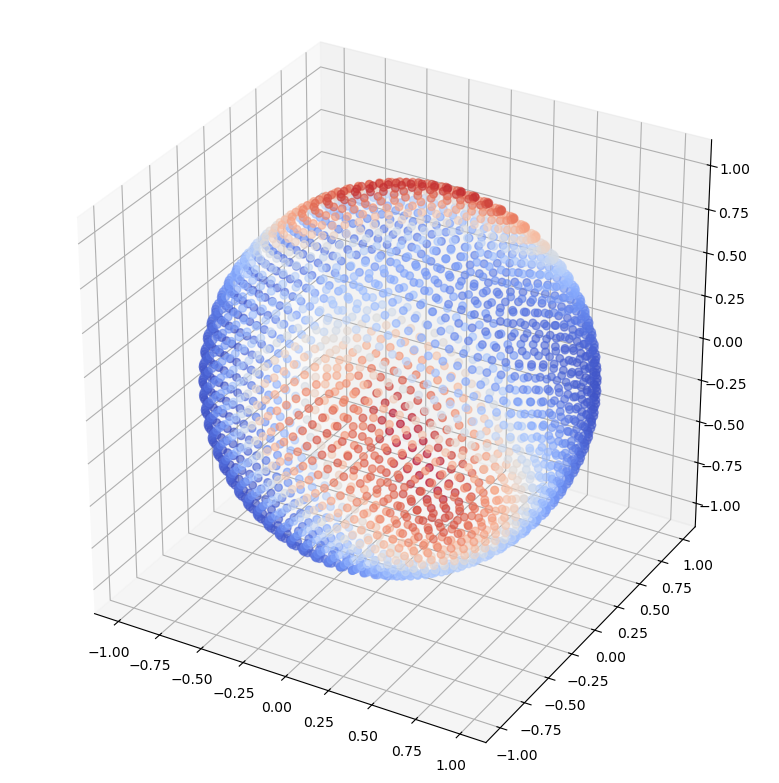

In [99]:
np.random.seed(5)

num_samp = 2500

mesh_points = generate_unit_sphere_mesh(n_points=num_samp)

# Define 3 well-separated mode centers
modes = np.array([
    [1, 0, 0],
    [0,0,1],
    [0,0,-1],
    [-1,0, 0],
    [0,1,0],
    [0,-1,0]
])+ 2*(np.random.rand(6,3)-1/2)

theta = (6/16)*np.pi
    
modes = modes@np.array([[np.cos(theta),np.sin(theta),0],[-np.sin(theta),np.cos(theta),0],[0,0,1]])

# modes = modes@np.array([[1,0,0],[0,1,0],[0,0,-1]])

modes = modes / np.linalg.norm(modes, axis=1, keepdims=True)

# Define PDF
pdf_values = spherical_pdf(mesh_points, centers=modes, bandwidth=0.4)

# Build graph
G = build_graph_on_sphere(mesh_points, pdf_values, k=10)

### Plot
pos = nx.get_node_attributes(G, 'pos')
pdf = nx.get_node_attributes(G, 'pdf')

xyz = np.array([pos[i] for i in G.nodes()])
pdf_vals = np.array([pdf[i] for i in G.nodes()])

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], c=pdf_vals, cmap='coolwarm', s=30, alpha = 0.6)
ax.set_box_aspect([1,1,1])
plt.savefig('sphere_distribution_randomized.png', format='png', dpi=300)
plt.tight_layout()
plt.show()


In [100]:
dx = 4*np.pi/num_samp
p=2
D = sphere_distances(mesh_points)
deviation_values = np.sum(D**p*pdf_values*dx,axis = 1)**(1/p)

In [101]:
f = {i:deviation_values[i] for i in range(len(G))}

T = simplify_merge_tree(get_merge_tree(G,f))

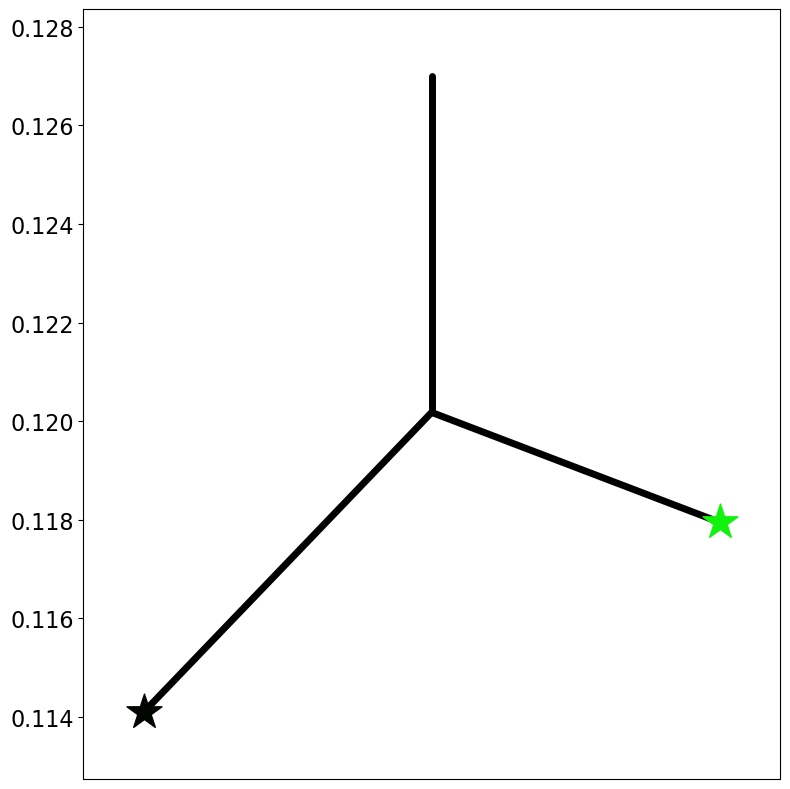

In [102]:
height = {node:T.nodes[node]['height'] for node in T.nodes()}
pos = mergeTree_pos(T,height)

fig, ax = plt.subplots(figsize=(8, 8))

nx.draw_networkx(T, pos=pos, with_labels=False,node_size = 15, node_color = 'black',width = 5)

leaves = [node for node in T if nx.degree(T)[node] == 1]
leaves.pop();

# Define a fixed green hue (around 120 degrees -> 120/360 = 0.33 in HSL)
hue = 0.33         # green
saturation = 0.9   # strong green
lightness_vals = np.linspace(0.01,0.99,len(leaves)+1)  # from dark to light

# Generate list of green colors in increasing lightness
green_colors = [colorsys.hls_to_rgb(hue, l, saturation) for l in lightness_vals]

# Optionally convert RGB values to hex for use in matplotlib
green_colors_hex = [mcolors.to_hex(rgb) for rgb in green_colors]

for i,node in enumerate(leaves):
    
    x_min = np.array([pos[node][0]])
    y_min = np.array([pos[node][1]])
    plt.scatter(x_min, y_min, color=green_colors_hex[i], s=700, marker="*", label="Fréchet Means", alpha=1,zorder=10)

ax.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, labelsize = 16)
# ax.set_ylim(1.5, 2.2)
plt.tight_layout()
plt.savefig('sphere_distribution_tree_random.png', format='png', dpi=300)

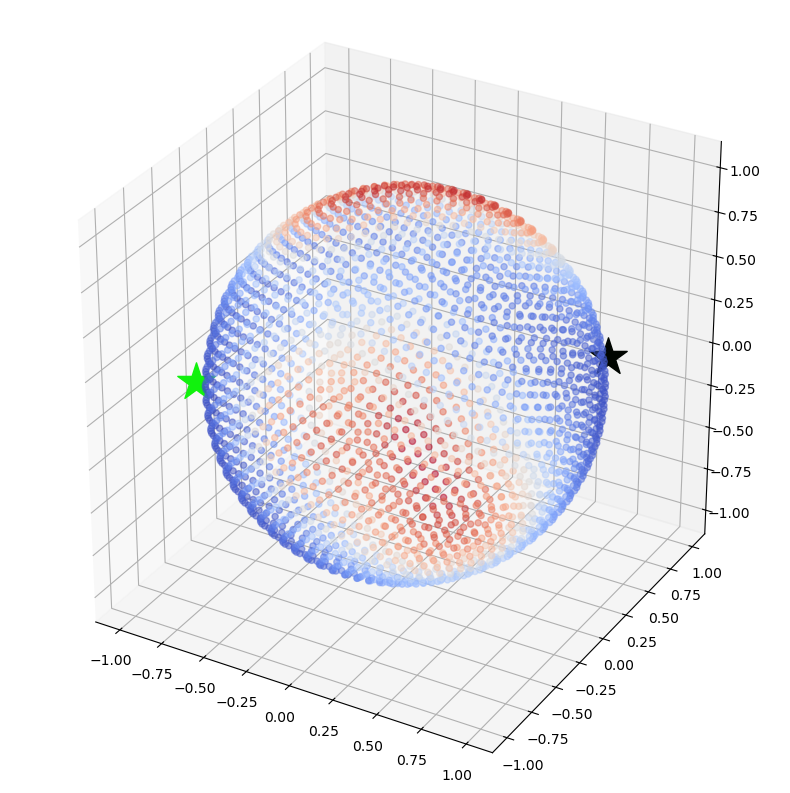

In [103]:
# Build graph
G1 = build_graph_on_sphere(mesh_points, deviation_values, k=10)

# Visualize
# visualize_graph_on_sphere(G1)

pos1 = nx.get_node_attributes(G1, 'pos')
pdf1 = nx.get_node_attributes(G1, 'pdf')

xyz = np.array([pos1[i] for i in G1.nodes()])
pdf_vals1 = np.array([pdf1[i] for i in G1.nodes()])
x_sphere = 1.05*xyz[:,0]
y_sphere = 1.05*xyz[:,1]
z_sphere = 1.05*xyz[:,2]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

for i,node in enumerate(leaves):
    
    other_node_value = get_key(f,T.nodes[node]['height'])[0]
    ax.scatter(x_sphere[other_node_value], y_sphere[other_node_value], z_sphere[other_node_value], color=green_colors_hex[i], s=800, marker="*", label="Fréchet Means", alpha=1,zorder=1)
    
ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], c=pdf_vals, cmap='coolwarm', s=20, alpha = 0.5)

ax.set_box_aspect([1,1,1])
plt.tight_layout()
plt.savefig('sphere_distribution_means_random.png', format='png', dpi=300)